# ChannelTS Object

A `ChannelTS` object is a container for a single channel.  The data are stored in an `xarray.DataArray` and indexed by time according to the metadata provided.  Here we will make a simple `electric` channel and look at how to interogate it.

To get a `ChannelTS` object from an MTH5 file you can use

```
ch_dataset = mth5_object.get_channel("station", "run", "ex", survey="survey")
ch_ts = ch_dataset.to_channel_ts()
```

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS
from mt_metadata.timeseries import Electric, Run, Station

## Create Synthetic ChannelTS
Here create some metadata, the keys are the `time_period.start` and the `sample_rate`. 

In [22]:
ex_metadata = Electric()
ex_metadata.time_period.start = "2020-01-01T00:00:00"
ex_metadata.sample_rate = 1.0
ex_metadata.component = "ex"
ex_metadata.dipole_length = 100.
ex_metadata.units = "milliVolt"

Create `Station` and `Run` metadata

In [3]:
station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

Create "realistic" data 

In [4]:
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

In [5]:
ex = ChannelTS(channel_type="electric",
              data=data,
              channel_metadata=ex_metadata,
              run_metadata=run_metadata,
              station_metadata=station_metadata)

In [6]:
ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:15+00:00
	N Samples:    4096

## Plot Timeseries

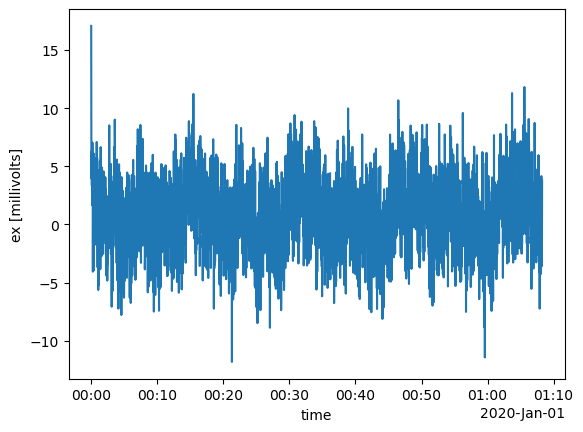

In [32]:
ex.plot()

## Plot Spectra

C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\timeseries\channel_ts.py:1634: RuntimeWarning: divide by zero encountered in divide
  ax.loglog(1.0 / plot_frequency, power, lw=1.5)


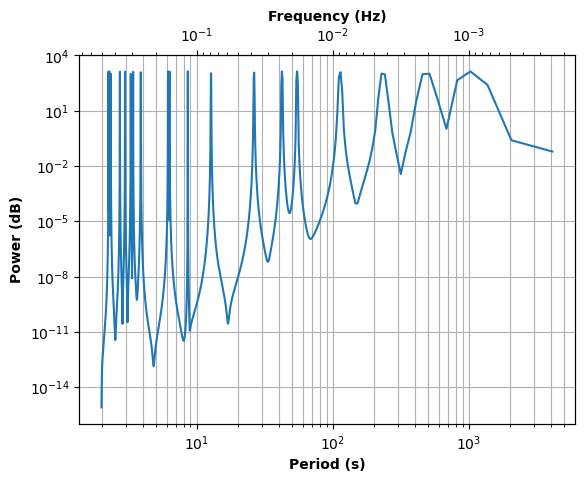

In [33]:
ex.plot_spectra()

## Get a slice of the data
Here we will provide a start time of the slice and the number of samples that we want the slice to be


In [7]:
ex_slice = ex.get_slice("2020-01-01T00:00:00", n_samples=256)

In [8]:
ex_slice

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:04:15+00:00
	N Samples:    256

### Plot Slice

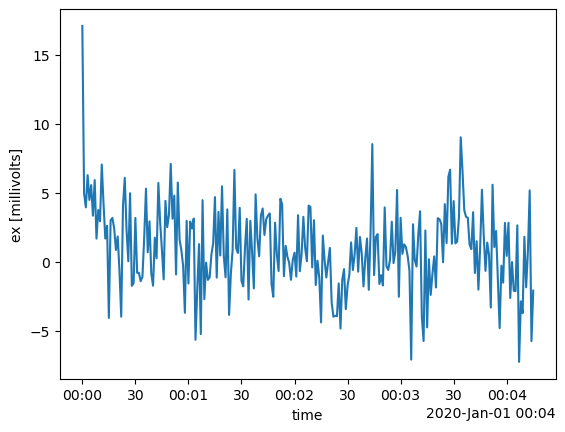

In [9]:
ex_slice.plot()

## Downsample

Many times its advantageous to downsample the data for processing or visualization.  There are a few methods for downsampling including

| Method | Description |
|--------|-------------|
| `decimate` | classic decimation: apply an anti-alias window then down sample by up to a factor of 8, if more are required repeat |
| `resample` | no anti-alias filter just simply pick samples at the new sample rate |
| `resample_poly` | upsampled, an FIR zero-phase low pass filter is applied then downsampled, efficient and most accurate **preferred method** | 

<div class="alert alert-block alert-info">
<b>Note:</b> The recommended method is resample_poly which is more accurate as it does not assume a periodic signal.
</div>



In [10]:
ex_resample_poly = ex.resample_poly(.25)

In [11]:
ex_resample_poly

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  0.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:12+00:00
	N Samples:    1024

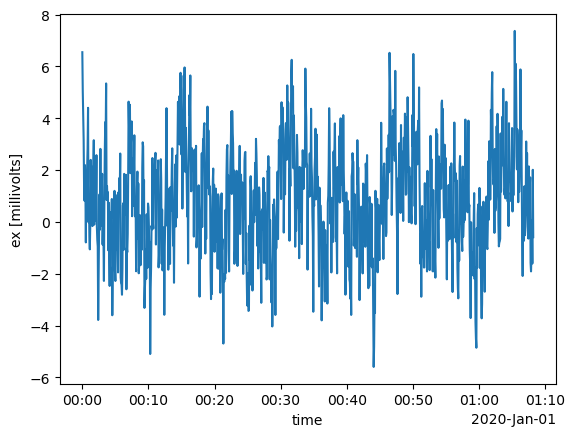

In [12]:
ex_resample_poly.plot()

## Convert to an `xarray`
We can convert the `ChannelTS` object to an `xarray.DataArray` which could be easier to use.

In [13]:
ex_xarray = ex.to_xarray()

In [14]:
ex_xarray

<xarray.DataArray 'ex' (time: 4096)> Size: 33kB
array([17.07665608,  4.94122118,  3.94350118, ..., -1.38886803,
       -0.92317085,  3.77193953], shape=(4096,))
Coordinates:
  * time     (time) datetime64[ns] 33kB 2020-01-01 ... 2020-01-01T01:08:15
Attributes: (12/27)
    channel_number:             0
    component:                  ex
    data_quality.rating.value:  0
    dipole_length:              100.0
    filter.applied:             [True]
    filter.name:                []
    ...                         ...
    time_period.end:            2020-01-01T01:08:15+00:00
    time_period.start:          2020-01-01T00:00:00+00:00
    type:                       electric
    units:                      millivolts
    station.id:                 mt001
    run.id:                     001

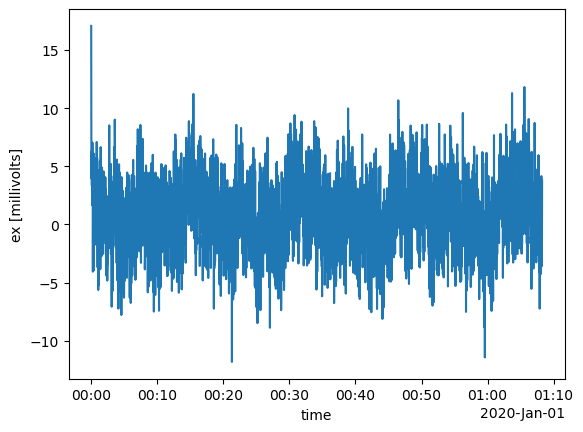

In [15]:
ex_xarray.plot()

## Convert to an `Obspy.Trace` object
The `ChannelTS` object can be converted to an `obspy.Trace` object.  This can be useful when dealing with data received from a mainly seismic archive like IRIS.  This can also be useful for using some tools provided by [Obspy](https://docs.obspy.org/).  

**Note** there is a loss of information when doing this because an `obspy.Trace` is based on miniSEED data formats which has minimal metadata.  

In [16]:
ex.station_metadata.fdsn.id = "mt001"
ex_trace = ex.to_obspy_trace()

c:\Users\peaco\miniconda3\envs\py311\Lib\site-packages\obspy\core\util\attribdict.py:199: UserWarning: Attribute "network" must be of type <class 'str'>, not <class 'NoneType'>. Attempting to cast None to <class 'str'>
  warnings.warn(msg)


In [17]:
ex_trace

None.MT001..LQN | 2020-01-01T00:00:00.000000Z - 2020-01-01T01:08:15.000000Z | 1.0 Hz, 4096 samples

## Convert from an `Obspy.Trace` object
We can reverse that and convert an `obspy.Trace` into a `ChannelTS`.  Again useful when dealing with seismic dominated archives.

In [18]:
ex_from_trace = ChannelTS()
ex_from_trace.from_obspy_trace(ex_trace)

In [19]:
ex_from_trace

Channel Summary:
	Survey:       0
	Station:      MT001
	Run:          sr1_001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:15+00:00
	N Samples:    4096

In [20]:
ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:15+00:00
	N Samples:    4096

On comparison you can see the loss of metadata information.  

## Logic

Overloads of some basic functionality are provided for `==`, `>`, `<` and `+`.

### Equals

This tests if the metadata and data are equal between two `ChannelTS` objects.

Here we are testing the original `ex` and the resampled `ex`, so they should not be equal.  The logging messages provides information on which is not equal like the sampling rate and the end time.


In [24]:
ex == ex_resample_poly

2025-09-24T22:15:39.722270-0700 | INFO | mt_metadata.base.metadata | __eq__ | sample_rate: 0.0 != 1.0
2025-09-24T22:15:39.722270-0700 | INFO | mt_metadata.base.metadata | __eq__ | time_period.end: 2020-01-01T01:08:12+00:00 != 2020-01-01T01:08:15+00:00


False

In [26]:
other_ex = ex.copy()
other_ex.start = ex.end + 10 
other_ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T01:08:25+00:00
	End:          2020-01-01T02:16:40+00:00
	N Samples:    4096

In [28]:
ex < other_ex

2025-09-24T22:19:26.378242-0700 | INFO | mth5.timeseries.channel_ts | __lt__ | Only testing start time


False

### Adding Channels

Here we will add two channels `ex` and `other_ex`.

In [29]:
combined_ex = ex + other_ex
combined_ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T02:16:40+00:00
	N Samples:    8201

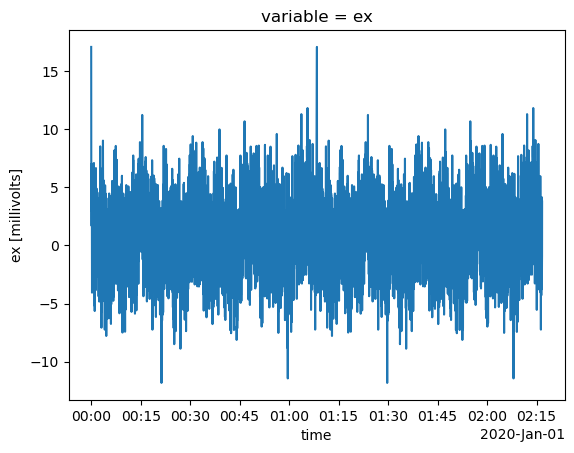

In [30]:
combined_ex.plot()

## Merge 

A different method for combining `ChannelTS` objects is to use the `merge` method.  The advantage of using `merge` is that it provides a way to fill time gaps and resample as well.

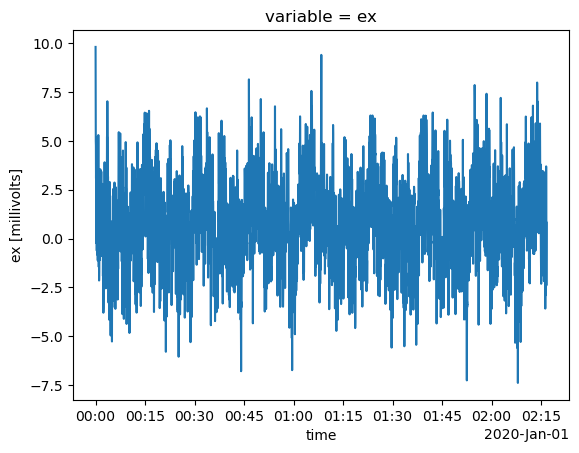

In [31]:
resample_other_ex = ex.merge(
    other_ex, 
    gap_method="slinear",
    new_sample_rate=0.5,
    resample_method="poly"
)

resample_other_ex.plot()

## Calibrate 

Removing the instrument response to calibrate the data is an important step in processing the data.  A convenience function `ChannelTS.remove_instrument_response` is supplied just for this.  
Currently, it will calibrate the whole time series at once and therefore may be slow for large data sets.  

**SEE ALSO**: `Make Data From IRIS` examples for working examples.

In [21]:
help(ex.remove_instrument_response)

Help on method remove_instrument_response in module mth5.timeseries.channel_ts:

remove_instrument_response(include_decimation=False, include_delay=False, **kwargs) method of mth5.timeseries.channel_ts.ChannelTS instance
    Remove instrument response from the given channel response filter
    
    The order of operations is important (if applied):
    
        1) detrend
        2) zero mean
        3) zero pad
        4) time window
        5) frequency window
        6) remove response
        7) undo time window
        8) bandpass
    
    :param include_decimation: Include decimation in response,
     defaults to True
    :type include_decimation: bool, optional
    :param include_delay: include delay in complex response,
     defaults to False
    :type include_delay: bool, optional
    
    **kwargs**
    
    :param plot: to plot the calibration process [ False | True ]
    :type plot: boolean, default True
    :param detrend: Remove linar trend of the time series
    :type de